In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [2]:
data = pd.read_excel("/Users/yj.noh/Desktop/churn_rider.xlsx")
print(data.head(2))
print(data.shape) #10,407

          brms_rider_id     max_day  cnt_ord  sum_fee  not_period
0  23070825800031604537  2023-10-10       68   297890          56
1  21092956038731394392  2023-10-18      166  1025220          48
(10407, 5)


# 2. matching - 층화추출

In [3]:
# cnt_ord, sum_fee, not_period 층화추출하기 
data['cnt_ord_group'] = pd.qcut(data['cnt_ord'], 5, labels=False)
data['sum_fee_group'] = pd.qcut(data['sum_fee'], 5, labels=False)
data['not_period_group'] = pd.qcut(data['not_period'], 5, labels=False)

print(data['cnt_ord_group'].value_counts())
print(data['sum_fee_group'].value_counts())
print(data['not_period_group'].value_counts())

cnt_ord_group
0    2188
2    2092
4    2079
3    2026
1    2022
Name: count, dtype: int64
sum_fee_group
4    2082
0    2082
3    2081
1    2081
2    2081
Name: count, dtype: int64
not_period_group
0    2342
3    2191
1    2036
2    1983
4    1855
Name: count, dtype: int64


In [4]:
# 층화추출을 위한 조합 생성
strata = data.groupby(['cnt_ord_group', 'sum_fee_group', 'not_period_group'])

# 각 조합별로 실험군과 대조군 생성
stratified_samples = []
for _, group_data in strata:
    # 그룹의 크기가 1보다 큰 경우에만 분할
    if len(group_data) > 1:
        experimental, control = train_test_split(group_data, test_size=0.5, random_state=42)
        experimental['group'] = 'experimental'
        control['group'] = 'control'
        stratified_samples.append(experimental)
        stratified_samples.append(control)
    else:
        # 그룹의 크기가 1인 경우, 해당 샘플을 한 번만 추가
        group_data['group'] = 'single_sample'
        stratified_samples.append(group_data)

# 모든 층화된 샘플을 하나의 DataFrame으로 결합
stratified_data = pd.concat(stratified_samples)

# 결과 확인
print(stratified_data[['brms_rider_id', 'cnt_ord', 'cnt_ord_group', 'sum_fee', 'sum_fee_group', 'not_period','not_period_group', 'group']].head())
print(stratified_data.shape) #16671


              brms_rider_id  cnt_ord  cnt_ord_group  sum_fee  sum_fee_group  \
7269   21102716843653379707       12              0    72300              0   
2230   21091784806373971097       15              0    51700              0   
10400  21082587962041698578       13              0    70600              0   
5452   21060768300903505752       10              0    31900              0   
8868   23030199072389316538       11              0    43360              0   

       not_period  not_period_group         group  
7269           30                 0  experimental  
2230           30                 0  experimental  
10400          28                 0  experimental  
5452           32                 0  experimental  
8868           32                 0  experimental  
(10407, 9)


In [5]:
stratified_data['group'].value_counts()

group
control          5222
experimental     5184
single_sample       1
Name: count, dtype: int64

In [6]:
final_df = stratified_data[stratified_data['group'].isin(['control', 'experimental'])]
print(final_df.shape) #10,595

(10406, 9)


In [7]:
print(final_df.isna().sum())

brms_rider_id       0
max_day             0
cnt_ord             0
sum_fee             0
not_period          0
cnt_ord_group       0
sum_fee_group       0
not_period_group    0
group               0
dtype: int64


In [8]:
numerical_columns = ['cnt_ord', 'sum_fee', 'not_period']

# 수치형 변수에 대한 t-test 및 Wilcoxon rank sum test
for col in numerical_columns:
    control = final_df[final_df['group'] == 'control'][col]
    experimental = final_df[final_df['group'] == 'experimental'][col]

    ttest_pvalue = stats.ttest_ind(control, experimental, equal_var=False).pvalue
    wilcoxon_pvalue = stats.ranksums(control, experimental).pvalue

    print(f"{col} - t-test p-value: {ttest_pvalue}")
    print(f"{col} - Wilcoxon rank sum test p-value: {wilcoxon_pvalue}")

cnt_ord - t-test p-value: 0.5297438898330663
cnt_ord - Wilcoxon rank sum test p-value: 0.9888358005636909
sum_fee - t-test p-value: 0.5295748747306315
sum_fee - Wilcoxon rank sum test p-value: 0.8483800421231291
not_period - t-test p-value: 0.8439598465663927
not_period - Wilcoxon rank sum test p-value: 0.8356153578609301


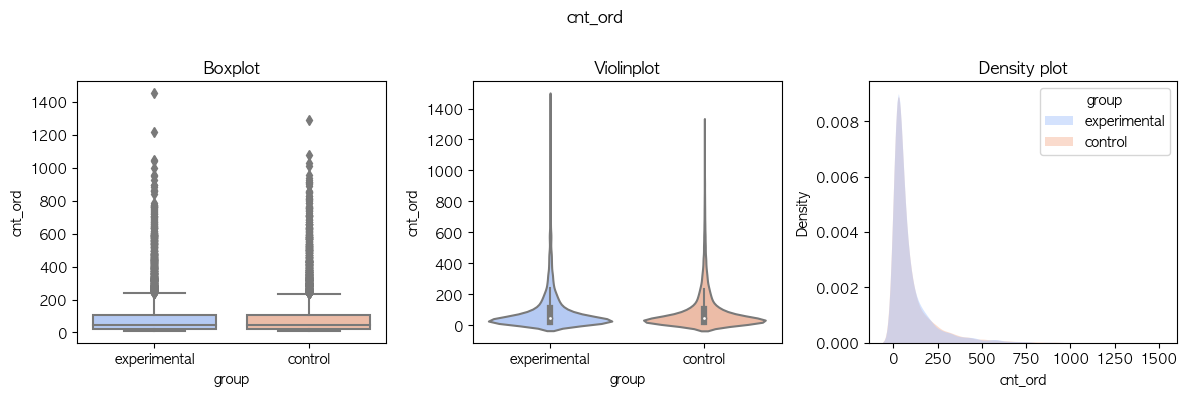

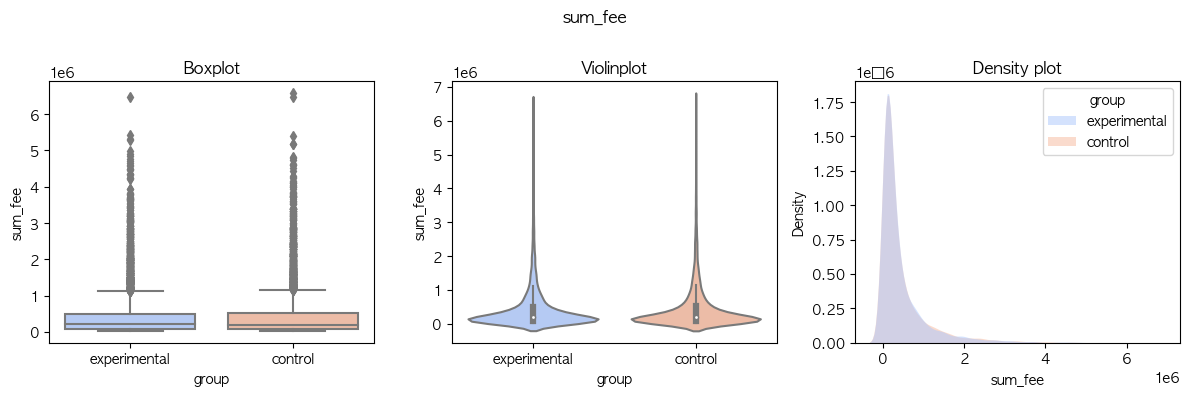

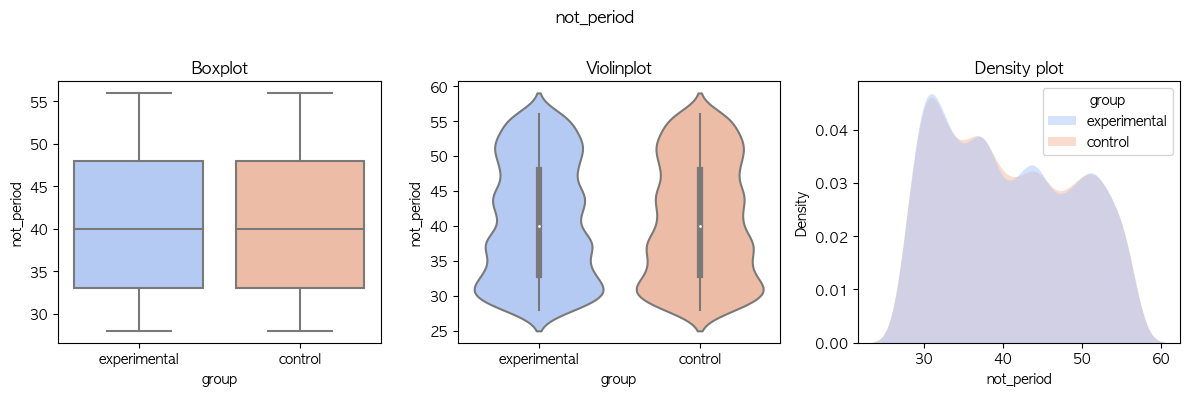

In [9]:
def plot_numeric (data, numeric_vars, outcome):
    
    palette = 'coolwarm'
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        fig.suptitle(f'{num_var}', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) 
        plt.show()
        plt.close(fig)

plot_numeric(final_df, numerical_columns, 'group')

In [10]:
data_df = final_df[final_df['group'] == 'experimental']
data_df = data_df[['brms_rider_id', 'cnt_ord', 'sum_fee']]
print(data_df.shape)
data_df.to_excel ("/Users/yj.noh/Desktop/test_set.xlsx", index = False, header=['brms_rider_id','건', '원'])

(5184, 3)


In [11]:
total_df = final_df
print(total_df.head(2))

total_df.to_excel("/Users/yj.noh/Desktop/total_set.xlsx", index = False)

             brms_rider_id     max_day  cnt_ord  sum_fee  not_period  \
7269  21102716843653379707  2023-11-05       12    72300          30   
2230  21091784806373971097  2023-11-05       15    51700          30   

      cnt_ord_group  sum_fee_group  not_period_group         group  
7269              0              0                 0  experimental  
2230              0              0                 0  experimental  
